In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import jax
from jax import grad, jit, vmap, jacfwd, jacrev, value_and_grad, jvp
import jax.numpy as jnp
import jax.random as jr

jax.config.update("jax_enable_x64", True)
colors = sns.color_palette()
key = jr.PRNGKey(0)

# Brownian Motion

To be clear on terms and provide some background, Brownian motion was originally observed as a physical phenomenon, particle of pollen suspended in water ([Einstein explains](https://www.damtp.cam.ac.uk/user/gold/pdfs/teaching/old_literature/Einstein1905.pdf) the phenomena in one of his <i>annus mirabilis</i> papers). The mathematical model of Brownian motion was developed by [Norbert Wiener](https://djalil.chafai.net/docs/M2/history-brownian-motion/Wiener%20-%201923.pdf) in the 1920s.
For our purposes, we will be using the terms Brownian motion and Wiener process interchangeably. 

The Wiener process is a continuous-time stocahstic process that plays an important role in many parts of mathematics and physics. It is the continuous time version of a discrete random walk. Let's go ahead and construct it as the limit of a random walk. The random walk is defined as:

$$
S_n = \sum_{i=1}^{n} X_i
$$

where $X_i$ are independent and identically distributed random variables with mean 0 and variance of 1 in this example. Let's then the define the driffusively rescaled random walk as:

$$
W(t) = \frac{1}{\sqrt{n}} S_{nt}
$$

where $t \in [0,1]$. The Wiener process is then defined as the limit of the driffusively rescaled random walk as $n \to \infty$. We can simulate the Wiener process by simulating the random walk and then taking the limit, this is called the Donsker construction. Let's go ahead and do it.

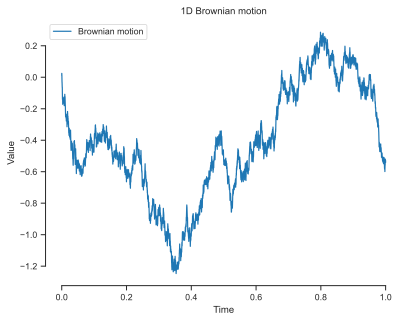

In [2]:
def random_walk(key, n):
    """
    Generate a random walk sequence S_n based on i.i.d. random variables.

    Args:
        key: PRNG key for reproducibility.
        n: Length of the random walk.

    Returns:
        Random walk sequence S_n.
    """
    # Generate n i.i.d. random variables with mean 0 and variance 1
    x = jr.normal(key, shape=(n,))
    # Compute partial sums
    S_n = jnp.cumsum(x)
    return S_n

def limit_random_walk(key, n, t_points):
    """
    Generate a Brownian motion (diffusively rescaled random walk).

    Args:
        key: PRNG key for reproducibility.
        n: Number of steps in the random walk.
        t_points: Array of time points in [0, 1] at which to evaluate the process.

    Returns:
        Array of Brownian motion values at specified t_points.
    """
    # Generate random walk sequence
    S_n = random_walk(key, n)
    # Map t_points to indices ⌊nt⌋
    indices = jnp.floor(n * t_points).astype(int)
    # Rescale by √n to get diffusively rescaled random walk
    W_n_t = S_n[indices] / jnp.sqrt(n)
    return W_n_t

# Number of steps in random walk
n_steps = 10000 
t_points = jnp.linspace(0, 1, n_steps)

# Generate Brownian motion
bm_values = limit_random_walk(key, n_steps, t_points)

# Visualize
fig, ax = plt.subplots()
ax.plot(t_points, bm_values, label="Brownian motion")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.set_title("1D Brownian motion")
ax.legend()
sns.despine(trim=True)
plt.show()

Now as n goes to infinity, this discrete random walk converges to the Wiener process. Try playing with the number of steps to see it converge.

Now for actually simulation the Wiener process we can use the following algorithm:

$$
W(0) = 0
$$

$$
W(t) = W(t-1) + \sqrt{\Delta t} Z
$$

where $Z$ is a standard normal random variable and $\Delta t$ is the time step. Let's go ahead and simulate the Wiener process.

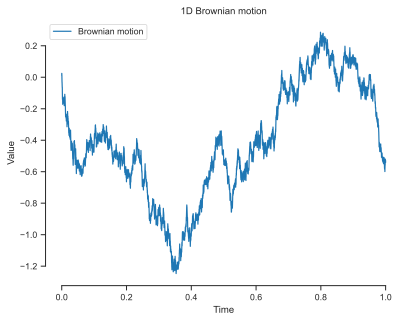

In [3]:
# define the Brownian motion without the random walk function
def brownian_motion_1d(key, n_steps):
    dt = 1.0 / n_steps
    dW = jnp.sqrt(dt) * jr.normal(key, (n_steps,))
    W = jnp.cumsum(dW)
    return W

# Number of steps in random walk
n_steps = 10000 
t_points = jnp.linspace(0, 1, n_steps)

# Generate Brownian motion
bm_values = brownian_motion_1d(key, n_steps)

# Visualize
fig, ax = plt.subplots()
ax.plot(t_points, bm_values, label="Brownian motion")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.set_title("1D Brownian motion")
ax.legend()
sns.despine(trim=True)
plt.show()

Notice it is the same as the limit of the driffusively rescaled random walk (if you use the same key and number of steps).

Okay, you can see how it is random, let try simulating it a few times to see how it behaves.

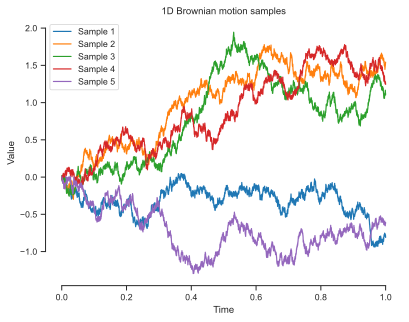

In [4]:
n_samples = 5

# Generate multiple Brownian motion samples
bm_samples = vmap(lambda key: brownian_motion_1d(key, n_steps))(jr.split(key, n_samples))

# Visualize
fig, ax = plt.subplots()
for i in range(n_samples):
    ax.plot(t_points, bm_samples[i], color=colors[i], label=f"Sample {i+1}")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.set_title("1D Brownian motion samples")
ax.legend()
sns.despine(trim=True)
plt.show()

So starting from the same spot, the Wiener process will take different paths each time. Some basic properties of the Winer process:

\begin{align*}
\mathbb{E}[W(t)] &= 0 \\
\mathbb{V}[W(t)] &= t
\end{align*}

Let's go ahead and check that.

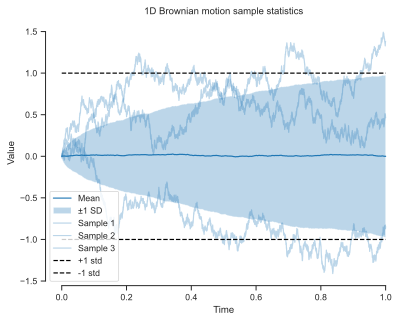

In [5]:
# Sample many Brownian motion paths and compute the mean and variance at each time point
n_samples = 1000
bm_samples = vmap(lambda key: 
                  brownian_motion_1d(key, n_steps))(jr.split(key, n_samples))
mean_values = jnp.mean(bm_samples, axis=0)
var_values = jnp.var(bm_samples, axis=0)

# Visualize
fig, ax = plt.subplots()
ax.plot(t_points, mean_values, label="Mean")
ax.fill_between(t_points, mean_values - jnp.sqrt(var_values), mean_values + jnp.sqrt(var_values), alpha=0.3, label="±1 SD")
# Plot a few samples
for i in range(3):
    ax.plot(t_points, bm_samples[i], color=colors[0], alpha=0.3, label=f"Sample {i+1}")
ax.hlines(1, 0, 1, color="black", linestyle="--", label="+1 std")
ax.hlines(-1, 0, 1, color="black", linestyle="--", label="-1 std")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.set_title("1D Brownian motion sample statistics")
ax.legend()
sns.despine(trim=True)
plt.show()

Let's plot the statstics as a function of time.

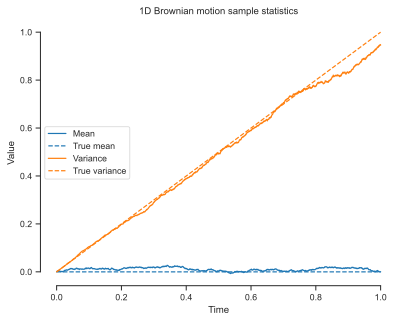

In [6]:
# Plot the mean and variance a function of time
fig, ax = plt.subplots()
ax.plot(t_points, mean_values, label="Mean")
ax.hlines(0, 0, 1, color=colors[0], linestyle="--", label="True mean")
ax.plot(t_points, var_values, label="Variance")
ax.plot(t_points, t_points, color=colors[1], linestyle="--", label="True variance")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.set_title("1D Brownian motion sample statistics")
ax.legend(loc="center left")
sns.despine(trim=True)
plt.show()

Notice that the expectation is indeed zero and the variance increases linearly with time.

Let's take a look at a Brownian motion in 2D. We can simulate it by simulating two independent Wiener processes and plotting them against each other.

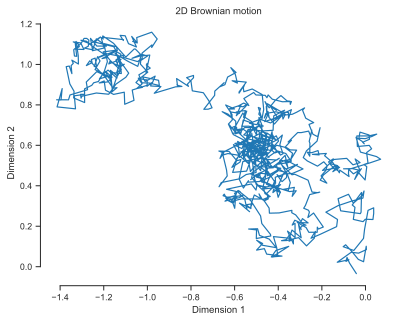

In [7]:
def brownian_motion_2d(key, n):
    """Generates a 2d Brownian motion with n steps."""
    key, subkey = jr.split(key)
    # Generate two independent 1D Brownian motions
    W_n_t = jnp.stack([brownian_motion_1d(key, n), 
                       brownian_motion_1d(subkey, n)], axis=1)
    return W_n_t

n_steps = 1000

# Generate 2D Brownian motion
bm_2d_values = brownian_motion_2d(key, n_steps)

# Visualize
fig, ax = plt.subplots()
ax.plot(bm_2d_values[:, 0], bm_2d_values[:, 1])
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_title("2D Brownian motion")
sns.despine(trim=True)
plt.show()


This would've been similar to the Brownian motion of particles phenomena being observed. Of course you can continue this to 3D and higher dimensions.

Let's now look at the Brownian bridge. It is a Wiener process that starts at 0 and ends at 0. We can define it as:

$$
B(t) = W(t) - \frac{t}{T} W(T)
$$

where $T$ is the final time. Let's go ahead and simulate it.

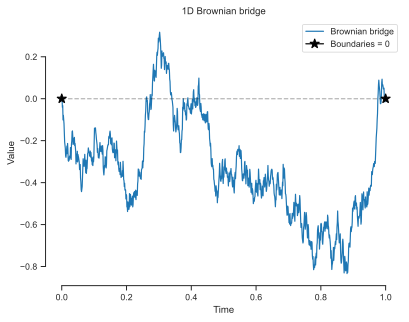

In [8]:
def brownian_bridge_1d(key, n, t_points):
    """
    Generate a Brownian bridge (conditioned Brownian motion to return to 0 at T).

    Args:
        key: PRNG key for reproducibility.
        n: Number of steps in the Brownian motion.
        t_points: Array of time points in [0, 1] at which to evaluate the process.

    Returns:
        Array of Brownian bridge values at specified t_points.
    """
    # Generate Brownian motion using the earlier function
    W_t = brownian_motion_1d(key, n)

    # Brownian Bridge transformation: B(t) = W(t) - t * W(T)
    # Define the end time
    T = -1 
    W_T = W_t[T]  # Value of Brownian motion at T
    B_t = W_t - t_points * W_T  # Apply the transformation

    return B_t

n_steps = 1000
t_points = jnp.linspace(0, 1, n_steps)

# Generate Brownian bridge
bb_values = brownian_bridge_1d(key, n_steps, t_points)

t_points = jnp.linspace(0, 1, n_steps)

# Visualize
fig, ax = plt.subplots()
ax.plot(t_points, bb_values, label="Brownian bridge")
ax.plot(0, 0, marker="*", markersize=10, color="black", label="Boundaries = 0")
ax.plot(1, 0, marker="*", markersize=10, color="black")
ax.hlines(0, 0, 1, color="black", alpha=0.3, linestyle="--")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.set_title("1D Brownian bridge")
ax.legend()
sns.despine(trim=True)
plt.show()


If we sample it many times, we will see that the variance decreases as we get closer to the end point.

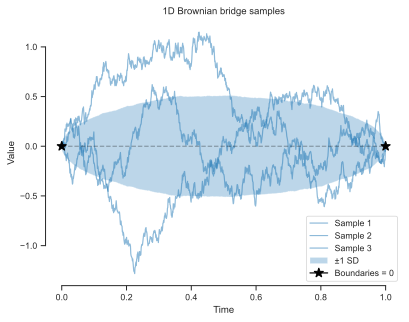

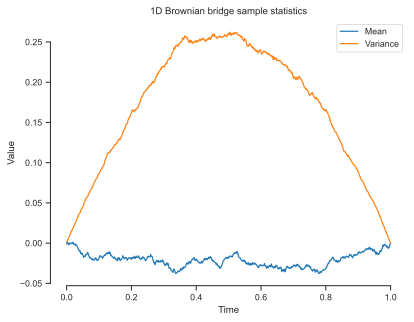

In [9]:
n_samples = 1000

# Generate multiple Brownian bridge samples
bb_samples = vmap(lambda key: 
                  brownian_bridge_1d(key, n_steps, t_points))(jr.split(key, n_samples))
bb_mean = jnp.mean(bb_samples, axis=0)
bb_var = jnp.var(bb_samples, axis=0)

# Visualize
fig, ax = plt.subplots()
for i in range(3):
    ax.plot(t_points, bb_samples[i], color=colors[0], alpha=0.5, label=f"Sample {i+1}")
ax.fill_between(t_points, -jnp.sqrt(bb_var), jnp.sqrt(bb_var), alpha=0.3, label="±1 SD")
# Plot big stars at the boundaries
ax.plot(0, 0, marker="*", markersize=10, color="black", label="Boundaries = 0")
ax.plot(1, 0, marker="*", markersize=10, color="black")
ax.hlines(0, 0, 1, color="black", alpha=0.3, linestyle="--")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.set_title("1D Brownian bridge samples")
ax.legend()
sns.despine(trim=True)
plt.show()

fig, ax = plt.subplots()
ax.plot(t_points, bb_mean, label="Mean")
ax.plot(t_points, bb_var, label="Variance")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.set_title("1D Brownian bridge sample statistics")
ax.legend()
sns.despine(trim=True)
plt.show()


This brownian bridge can be represented as its Karhunen-Loeve expansion. The Karhunen-Loeve expansion is a representation of a stochastic process as an infinite sum of orthogonal functions. The Karhunen-Loeve expansion of the Brownian bridge is given by:

$$
B(t) = \sum_{n=1}^{\infty} Z_n \frac{\sqrt{2} \sin(n \pi t)}{n \pi}
$$

where $Z_n$ are independent standard normal random variables. Let's go ahead and simulate the Brownian bridge.

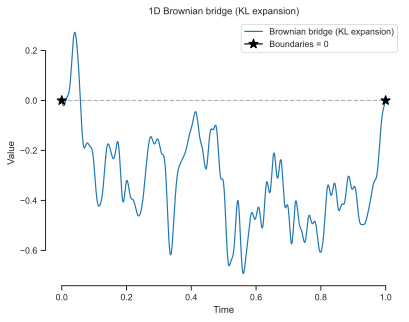

In [10]:
def brownian_bridge_kl(key, t_points, num_terms=100):
    """
    Generate a Brownian Bridge using the Karhunen–Loève (KL) expansion.

    Args:
        key: PRNG key for reproducibility.
        t_points: Array of time points in [0, 1] at which to evaluate the process.
        num_terms: Number of terms in the KL expansion.

    Returns:
        Array of Brownian Bridge values at specified t_points.
    """
    t_points = jnp.asarray(t_points)
    n = jnp.arange(1, num_terms + 1)  # KL expansion terms (1, 2, ..., num_terms)
    
    # Generate independent Gaussian random variables ξ_n ~ N(0, 1)
    keys = jr.split(key, num_terms)
    xi_n = jnp.array([jr.normal(k) for k in keys])
    
    # Compute the Brownian Bridge using the KL expansion
    terms = [
        xi_n[i] * jnp.sqrt(2)  * jnp.sin(n[i] * jnp.pi * t_points) / (jnp.pi * n[i])
        for i in range(num_terms)
    ]
    B_t = jnp.sum(jnp.stack(terms, axis=0), axis=0)
    
    return B_t

n_terms = 100

# Generate Brownian bridge using KL expansion
bb_kl_values = brownian_bridge_kl(key, t_points, num_terms=n_terms)

# Visualize
fig, ax = plt.subplots()
ax.plot(t_points, bb_kl_values, label="Brownian bridge (KL expansion)")
# Plot big stars at the boundaries
ax.plot(0, 0, marker="*", markersize=10, color="black", label="Boundaries = 0")
ax.plot(1, 0, marker="*", markersize=10, color="black")
ax.hlines(0, 0, 1, color="black", alpha=0.3, linestyle="--")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.set_title("1D Brownian bridge (KL expansion)")
sns.despine(trim=True)
ax.legend()
plt.show()

Okay, that doesn't look quite like we want, try playing around with the number of terms to see how many it takes to look like a Brownian bridge.

Let's see if we can recover the variance of the Brownian bridge with the expansion.

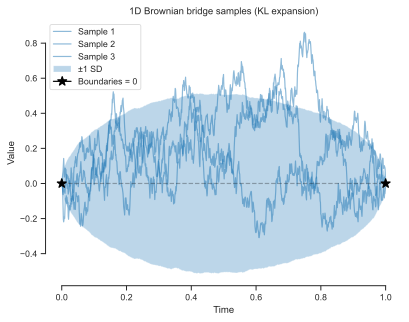

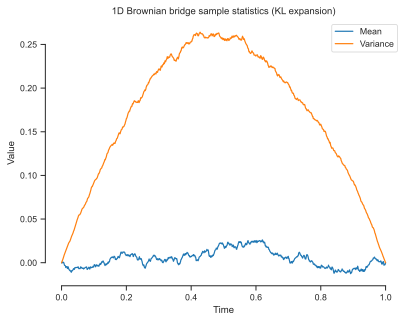

In [11]:
n_samples = 1000

n_terms = 1000

# Generate multiple Brownian bridge samples using KL expansion
bb_kl_samples = vmap(lambda key: 
                     brownian_bridge_kl(key, t_points, num_terms=n_terms))(jr.split(key, n_samples))
bb_kl_mean = jnp.mean(bb_kl_samples, axis=0)
bb_kl_var = jnp.var(bb_kl_samples, axis=0)

# Visualize
fig, ax = plt.subplots()
for i in range(3):
    ax.plot(t_points, bb_kl_samples[i], color=colors[0], alpha=0.5, label=f"Sample {i+1}")
ax.fill_between(t_points, -jnp.sqrt(bb_kl_var), jnp.sqrt(bb_kl_var), alpha=0.3, label="±1 SD")
# Plot big stars at the boundaries
ax.plot(0, 0, marker="*", markersize=10, color="black", label="Boundaries = 0")
ax.plot(1, 0, marker="*", markersize=10, color="black")
ax.hlines(0, 0, 1, color="black", alpha=0.3, linestyle="--")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.set_title("1D Brownian bridge samples (KL expansion)")
ax.legend()
sns.despine(trim=True)
plt.show()

# Plot the mean and variance a function of time
fig, ax = plt.subplots()
ax.plot(t_points, bb_kl_mean, label="Mean")
ax.plot(t_points, bb_kl_var, label="Variance")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.set_title("1D Brownian bridge sample statistics (KL expansion)")
ax.legend()
sns.despine(trim=True)
plt.show()

Okay great! The statistics of the Karhunen-Loeve expansion match the statistics of the Brownian bridge. 

Can you think of other phenomena that can be modeled as a Wiener process? 

In the next notebook we will take a look at how we can use the Wiener process to model stochastic systems.